# SVM with RBF Kernel and Feature Preprocessing

*Hayley Boyce, April 28th 2021*

In [1]:
# Importing our libraries
import pandas as pd
import altair as alt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_validate, train_test_split

import sys
sys.path.append('code/')
from display_tree import display_tree
from plot_classifier import plot_classifier
import matplotlib.pyplot as plt

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler

## House Keeping 
- Assignment due today at 11:59pm!
- Course feedback!
- Assignment - things I should know?
- Assignment2 - before or after the weekend?
- Polls coming Monday!
- I hear you don't like breakout rooms, let's try this lecture without them!
- Per the announcement Monday, download the data for this lecture [here](https://www.kaggle.com/harrywang/housing) and include it in your `data` folder that resides in `lectures`. 

## Lecture Learning Objectives 

- Identify when to implement feature transformations such as imputation and scaling.
- Describe the difference between normalizing and standardizing and be able to use scikit-learn's `MinMaxScaler()` and `StandardScaler()` to pre-process numeric features.
- Apply `sklearn.pipeline.Pipeline` to build a machine learning pipeline.
- Use `sklearn` for applying numerical feature transformations to the data.
- Discuss the golden rule in the context of feature transformations.

## Five Minute Recap/ Lightning Questions 

- When using a Dummy Regressor what value does the model predict for unseen data? 
- When using a Dummy Classifier (the one we examined in lecture) what class does the model predict for unseen data? 
- What is the name of the distance metric used in the $k$-nn model we looked at?
- If a dataset has 14 features and 1 target column, how many dimensions will the feature vector be?
- What is the hyperparameter name of the $k$-nn classifier we looked at last lecture?

### Some lingering questions

- How does a $k$-nn Regressor work?
- Are we ready to do machine learning on real-world datasets?
- We've looked at data with numeric features but what do we do if we have features with categories or string values?
- What happens if we are missing data in our features?
- Is there a cleaner way to do all the steps we need to do? 

## Regression with $k$-NN 

In $k$-nearest neighbour regression, we take the average of $k$-nearest neighbours instead of the majority vote.

Let's look at an example. 

Here we are creating some synthetic data with fifty examples and only one feature. 

We only have one feature of `length` and our goal is to predict `weight`. 

Regression plots more naturally in 1D, classification in 2D, but of course we can do either for any $d$

Right now, do not worry about the code and only focus on data and our model. 

In [73]:
np.random.seed(0)
n = 50
X_1 = np.linspace(0,2,n)+np.random.randn(n)*0.01
X = pd.DataFrame(X_1[:,None], columns=['length'])
X.head()

length
0  0.017641
1  0.044818
2  0.091420
3  0.144858
4  0.181941

In [75]:
y = abs(np.random.randn(n,1))*2 + X_1[:,None]*5
y = pd.DataFrame(y, columns=['weight'])
y.head()

weight
0  1.879136
1  0.997894
2  1.478710
3  3.085554
4  0.966069

In [76]:
snake_X_train, snake_X_test, snake_y_train, snake_y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Now let's visualize our training data. 

In [77]:
source = pd.concat([snake_X_train, snake_y_train], axis=1)

scatter = alt.Chart(source, width=500, height=300).mark_point(filled=True, color='green').encode(
    alt.X('length:Q'),
    alt.Y('weight:Q'))

scatter

alt.Chart(...)

Now let's try the $k$-nearest neighbours regressor on this data. 

Then we create our `KNeighborsRegressor` object with `n_neighbors=1` so we are only considering 1 neighbour and with `uniform` weights. 

In [6]:
from sklearn.neighbors import KNeighborsRegressor

knnr_1 = KNeighborsRegressor(n_neighbors=1, weights="uniform")
knnr_1.fit(snake_X_train,snake_y_train);

predicted = knnr_1.predict(snake_X_train)
predicted

array([[ 4.57636104],
       [13.20245224],
       [ 3.03671796],
       [10.74123618],
       [ 1.82820801],
       [ 0.99789449],
       [ 1.40502866],
       [ 6.65854422],
       [10.79334171],
       [ 5.8161302 ],
       [ 8.14709171],
       [ 3.88147008],
       [10.94245294],
       [ 7.05000467],
       [ 2.02594736],
       [ 5.41216429],
       [ 9.96904766],
       [ 3.08555393],
       [ 7.12642094],
       [ 9.66684202],
       [ 0.96606889],
       [ 6.60040677],
       [ 9.76601245],
       [ 3.2341883 ],
       [10.82632705],
       [ 6.39894271],
       [ 7.97098907],
       [10.05297199],
       [ 2.58274695],
       [ 7.41754784],
       [ 9.70814143],
       [ 6.8118191 ],
       [ 8.90266502],
       [ 3.93873703],
       [ 4.38469435],
       [ 9.87724094],
       [ 9.89788429],
       [ 6.41402974],
       [ 1.47871044],
       [10.57491609]])

If we scored over regressors we get this perfect score of one since we have `n_neighbors=1` we are likely to overfit.

In [7]:
knnr_1.score(snake_X_train, snake_y_train)  

1.0

Plotting this we can see our model is trying to get every example correct since n_neighbors=1. (the mean of 1 point is just going to be the point value)

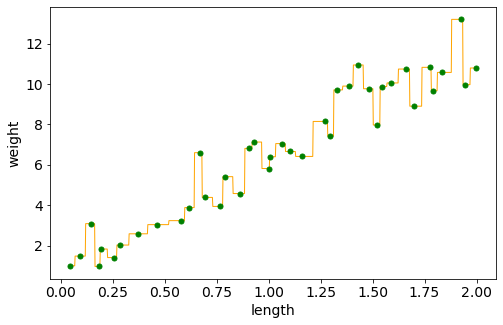

In [78]:
plt.figure(figsize=(8, 5))
grid = np.linspace(np.min(snake_X_train), np.max(snake_X_train), 1000)
plt.plot(grid, knnr_1.predict(grid), color='orange', linewidth=1)
plt.plot(snake_X_train, snake_y_train, ".r", markersize=10, color='green')
plt.xticks(fontsize= 14);
plt.yticks(fontsize= 14);
plt.xlabel("length",fontsize= 14)
plt.ylabel("weight",fontsize= 14);

What happens when we use `n_neighbors=10`?

In [84]:
knnr_10 = KNeighborsRegressor(n_neighbors=10, weights="uniform")
knnr_10.fit(snake_X_train, snake_y_train)
knnr_10.score(snake_X_train, snake_y_train)

0.9254540554756747

 Now we can see we are getting a lower score over the training set. Our score decreased from 1.0 when to had `n_neighbors=1` to now having a score of 0.925.  

When we plot our model, we can see that it no longer is trying to get every example correct. 

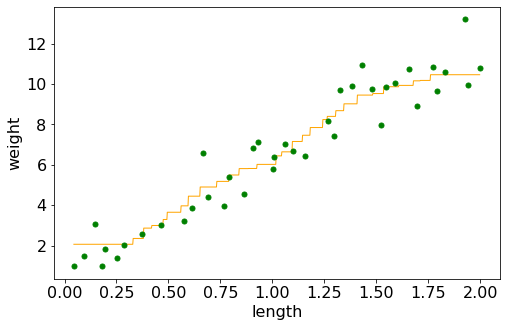

In [85]:
plt.figure(figsize=(8, 5))
plt.plot(grid, knnr_10.predict(grid), color='orange', linewidth=1)
plt.plot(snake_X_train, snake_y_train, ".r", markersize=10, color='green')
plt.xticks(fontsize= 16);
plt.yticks(fontsize= 16);
plt.xlabel("length",fontsize= 16)
plt.ylabel("weight",fontsize= 16);

## Pros and Cons of 𝑘 -Nearest Neighbours


### Pros:

- Easy to understand, interpret.
- Simply hyperparameter $k$ (`n_neighbors`) controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.
- Lazy learning: Takes no time to `fit`

<br>

### Cons:

- Can potentially be VERY slow during prediction time. 
- Often not that great test accuracy compared to the modern approaches.
- Need to scale your features. We'll be looking into this in an upcoming lecture (lecture 4 I think?). 


## Let's Practice

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}0\\0\\1\\1\\1\\2\end{bmatrix}.$$

If $k=3$, what would you predict for $x=\begin{bmatrix} 0\\0\end{bmatrix}$ if we were doing regression rather than classification?


```{admonition} Solutions!
:class: dropdown

1. 1/3 ($\frac{0 + 0 + 0}{3}$) 
```

## Support Vector Machines (SVMs) with RBF Kernel

Another popular similarity-based algorithm is Support Vector Machines (SVM).

SVMs use a different similarity metric which is called a “kernel” in "SVM land".

We are going to concentrate on the specific kernel called Radial Basis Functions (RBFs).

Back to the good ol' Canadian and USA cities data.

In [86]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
cities_train_df, cities_test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
cities_train_df.head()

longitude  latitude country
160   -76.4813   44.2307  Canada
127   -81.2496   42.9837  Canada
169   -66.0580   45.2788  Canada
188   -73.2533   45.3057  Canada
187   -67.9245   47.1652  Canada

In [87]:
cities_X_train = cities_train_df.drop(columns=['country'])
cities_y_train = cities_train_df['country']
cities_X_test = cities_test_df.drop(columns=['country'])
cities_y_test = cities_test_df['country']

cities_X_train.head()

longitude  latitude
160   -76.4813   44.2307
127   -81.2496   42.9837
169   -66.0580   45.2788
188   -73.2533   45.3057
187   -67.9245   47.1652

In [88]:
cities_y_train.head()

160    Canada
127    Canada
169    Canada
188    Canada
187    Canada
Name: country, dtype: object

Unlike with $k$-nn, we are  not going into detail about how support vector machine classifiers or regressor works but more so on how to use it with `sklearn`.

We can use our training feature table ($X$) and target ($y$) values by using this new SVM model with (RBF) but with the old set up with `.fit()` and `.score()` that we have seen time and time again. 

We import the `SVC` tool from the `sklearn.svm` library (The "C" in SVC represents  *Classifier*. 

To import the regressor we import `SVR` - R for *Regressor*)

In [89]:
from sklearn.svm import SVC

In [90]:
from sklearn.svm import SVR

We can cross-validate and score exactly how we saw before. 

(For now, ignore `gamma=0.01` we are addressing it coming up)

In [91]:
svm = SVC(gamma=0.01)
scores = cross_validate(svm, cities_X_train, cities_y_train, return_train_score=True)
pd.DataFrame(scores)

fit_time  score_time  test_score  train_score
0  0.012111    0.009785    0.823529     0.842105
1  0.003791    0.002616    0.823529     0.842105
2  0.003442    0.002914    0.727273     0.858209
3  0.003628    0.001606    0.787879     0.843284
4  0.002685    0.001821    0.939394     0.805970

In [92]:
svm_cv_score = scores['test_score'].mean()
svm_cv_score

0.8203208556149733

The biggest thing to know about support vector machines is that superficially, support vector machines are very similar to 𝑘-Nearest Neighbours.

You can think of SVM with RBF kernel as a "smoothed" version of the $k$-Nearest Neighbours.

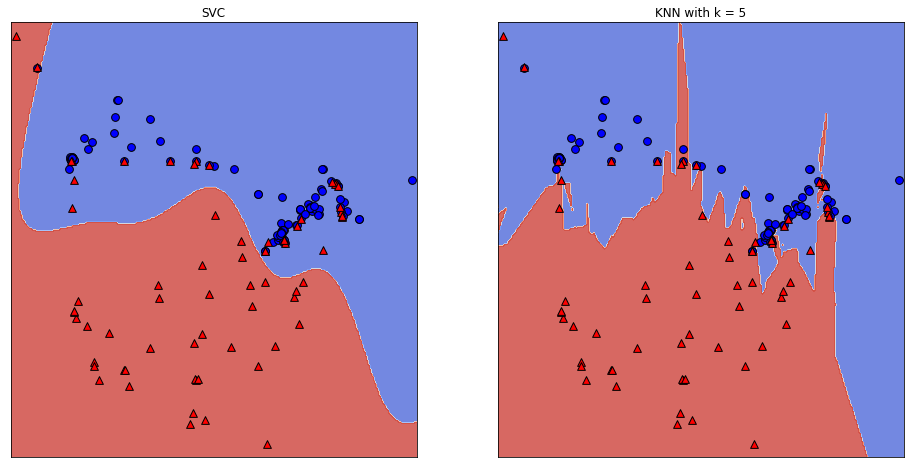

In [93]:
svm.fit(cities_X_train, cities_y_train);

kn5_model = KNeighborsClassifier(n_neighbors=5)
kn5_model.fit(cities_X_train, cities_y_train);

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("SVC")
plot_classifier(cities_X_train, cities_y_train, svm, ax=plt.gca())
plt.subplot(1, 2, 2)
plt.title("KNN with k = 5")
plot_classifier(cities_X_train, cities_y_train, kn5_model, ax=plt.gca());

An observation is classified as a positive class if on average it looks more like positive examples. An observation is classified as a negative class if on average it looks more like negative examples.

The primary difference between 𝑘-NNs and SVMs is that:

- Unlike $k$-NNs, SVMs only remember the key examples (Those examples are called **support vectors**). 
- When it comes to predicting a query point, we only consider the key examples from the data and only calculate the distance to these key examples. This makes it more efficient than 𝑘-NN. 

### Hyperparameters of SVM

There are  2 main hyperparameters for support vector machines with an RBF kernel;

- `gamma` 
- `C`
    
(told you we were coming back to it!) 

We are not equipped to understand the meaning of these parameters at this point but you are expected to describe their relationship to the fundamental tradeoff. 

(In short, `C` is the penalty the model accepts for wrongly classified examples, and `gamma` is the curvature (see [here](https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167) for more) 

See [`scikit-learn`'s explanation of RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)

#### `gamma` and the fundamental trade-off

`gamma` controls the complexity of a model, just like other hyperparameters we've seen.

- higher gamma, higher the complexity.
- lower gamma, lower the complexity.

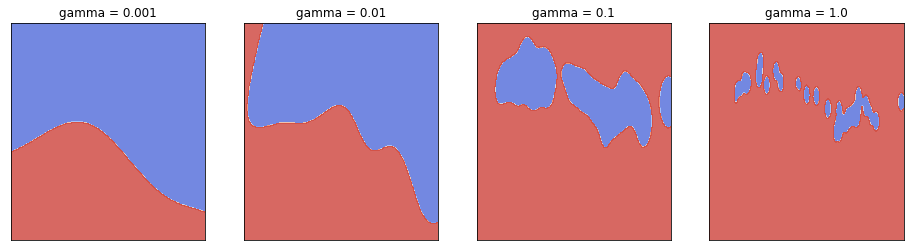

In [94]:
plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    gamma = 10.0 ** (i - 3)
    rbf_svm = SVC(gamma=gamma)
    rbf_svm.fit(cities_X_train, cities_y_train)
    plt.title("gamma = %s" % gamma);
    plot_classifier(cities_X_train, cities_y_train, rbf_svm, ax=plt.gca(), show_data=False)

#### `C` and the fundamental trade-off

`C` also controls the complexity of a model and in turn the fundamental tradeoff.

- higher `C` values, higher the complexity.
- lower `C` values, lower the complexity.

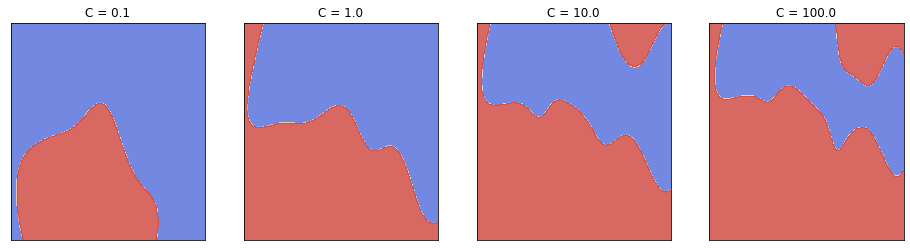

In [95]:
plt.figure(figsize=(16, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    C = 10.0 ** (i - 1)
    rbf_svm = SVC(C=C, gamma=0.01)
    rbf_svm.fit(cities_X_train, cities_y_train)
    plt.title("C = %s" % C);
    plot_classifier(cities_X_train, cities_y_train, rbf_svm, ax=plt.gca(), show_data=False)

Obtaining optimal validation scores requires a hyperparameter search between both `gamma` and `C` to balance the fundamental trade-off.
We will learn how to search over multiple hyperparameters at a time in lecture 5. 

## Let's Practice

**True or False** 

1\.In Scikit Learn’s SVC classifier, large values of gamma tend to result in higher training scores but probably lower validation scores.     
2\.If we increase both `gamma` and `C`, we can't be certain if the model becomes more complex or less complex.


```{admonition} Solutions!
:class: dropdown

1. True
2. False
```

## Let's Practice - Coding

Below is some starter code that creates your feature table and target column from the data from the `bball.csv` dataset (in the data folder).

In [167]:
bball_df = pd.read_csv('data/bball.csv')
bball_df = bball_df[(bball_df['position'] =='G') | (bball_df['position'] =='F')]

# Define X and y
X = bball_df.loc[:, ['height', 'weight', 'salary']]
y = bball_df['position']

1. Split the dataset into 4 objects: `X_train`, `X_test`, `y_train`, `y_test`. Make the test set 0.2 (or the train set 0.8) and make sure to use `random_state=7`.
2. Create an `SVM` model with `gamma` equal to 0.1 and `C` equal to 10.
3. Cross-validate using cross_validate() on the objects X_train and y_train specifying the model and making sure to use 5 fold cross-validation and `return_train_score=True`.
4. Calculate the mean training and cross-validation scores.

In [168]:
# 1. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

In [102]:
model = SVC(gamma=0.1, C=10)

In [169]:
# 3. Cross-validate
scores_df = pd.DataFrame(cross_validate(model,X_train,y_train, cv=5, return_train_score=True))

In [170]:
scores_df

fit_time  score_time  test_score  train_score
0  0.036492    0.020597    0.571429     0.994898
1  0.004584    0.002596    0.571429     0.994898
2  0.007812    0.002033    0.551020     0.994898
3  0.003463    0.001509    0.530612     1.000000
4  0.003535    0.002763    0.571429     0.994898

In [172]:
# 4. Calculate the mean training and cross-validation scores.
scores_df.mean()

fit_time       0.011177
score_time     0.005900
test_score     0.559184
train_score    0.995918
dtype: float64

In [173]:
scores_df.mean()['test_score']

0.5591836734693878

In [174]:
scores_df.mean()['train_score']

0.9959183673469388

## Preprocessing

### The importance of Preprocessing - An Example of Why

So far we have seen:   
 
- Models: Decision trees, 𝑘-NNs, SVMs with RBF kernel.
- Fundamentals: Train-validation-test split, cross-validation, the fundamental tradeoff, the golden rule.
 


Now ...
 
**Preprocessing**: Transforming input data into a format a machine learning model can use and understand.
 

#### Basketball dataset

Let's take a look at the `bball.csv` dataset we just used in practice.

- Let's look at the  3 feature columns `height`, `weight` and `salary`. 
- Let's see if these features can help predict the `position` basketball players is. 

In [108]:
bball_df = pd.read_csv('data/bball.csv')
bball_df = bball_df[(bball_df['position'] =='G') | (bball_df['position'] =='F')]
X = bball_df[['weight', 'height', 'salary']]
y =bball_df["position"]
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.20, random_state=123)

In [109]:
X_train.head()

weight  height     salary
152    79.4    1.88  1588231.0
337    82.1    1.91  2149560.0
130   106.6    2.03  6500000.0
340   106.1    2.08  2961120.0
50     96.2    1.93  4861207.0

In [110]:
y_train.head()

152    G
337    G
130    F
340    F
50     G
Name: position, dtype: object

First, let's see what validations scores we get if we simply predict the most occurring target value in the dataset using the dummy classifier model we saw in the last lecture.

In [111]:
dummy = DummyClassifier(strategy="most_frequent")
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
print('Mean training score', scores['train_score'].mean().round(2))
print('Mean validation score', scores['test_score'].mean().round(2))

Mean training score 0.57
Mean validation score 0.57


Here we get a mean validation score for our 5 fold cross_validation (5 is the default) of 57%. Let's now see how much better a $k$-nn model does on the data. We saw that it doesn't do to well on SVM, let's see if there is a difference with $k$-nn. 

In [112]:
knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train, y_train, return_train_score=True)
print('Mean training score', scores['train_score'].mean().round(2))
print('Mean validation score', scores['test_score'].mean().round(2))

Mean training score 0.7
Mean validation score 0.5


Ok, not the score we were hoping for. 

We are getting a worse score than the dummy classifier. This can't be right..... and it isn't and we are going to explain why!

Let's have a look at just 2 players. 

We can see the values in each column. 

In [113]:
two_players = X_train.sample(2, random_state=42)
two_players

weight  height     salary
285    91.2    1.98  1882867.0
236   112.0    2.08  2000000.0

- The values in the `weight` column are around 100.
- The values in the `height` column are around 2.
- The values in the `salary` column are much higher at around 2 million.

Let’s now calculate the distance between the two players.

In [114]:
euclidean_distances(two_players)

array([[     0.        , 117133.00184683],
       [117133.00184683,      0.        ]])

So the distance between the players is 117133.0018.

What happens if we only consider the salary column?

In [115]:
euclidean_distances(two_players[["salary"]])

array([[     0., 117133.],
       [117133.,      0.]])

It looks like it's almost the same distance!

The distance is completely dominated by the `salary` column, the feature with the largest values and the `weight` and `height` columns are being ignored in the distance calculation. 

**Does it matter?**

Yes! The scale is based on how data was collected.

Features on a smaller scale can be highly informative and there is no good reason to ignore them.
We want our model to be robust and not sensitive to the scale.

**What about for decision trees? Did scale matter then?**

No. In decision trees we ask questions on one feature at a time and so the nodes are created independently without considering others. 


We have to scale our columns before we use our $k$-nn algorithm (and many others) so they are all using a similar range of values!

And you guessed it - Sklearn has tools called transformers for this.

We'll be using `sklearn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for this example.
We will talk about this type of preprocessing in more detail in a hot minute but for now, concentrate on the syntax. 

In [116]:
from sklearn.preprocessing import StandardScaler

In [117]:
scaler = StandardScaler()                    # Create feature transformer object, can accept hyperparameters like models can! 
scaler.fit(X_train)                          # Fitting the transformer on the train split
X_train_scaled = scaler.transform(X_train)   # Transforming the train split
X_test_scaled = scaler.transform(X_test)     # Transforming the test split

`sklearn` uses `fit` and `transform` paradigms for feature transformations. (In model building it was `fit` and `predict` or `score`)

We `fit` the transformer on the train split and then `transform` the train split as well as the test split.

In [118]:
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

weight    height    salary
0 -1.552775 -1.236056 -0.728809
1 -1.257147 -0.800950 -0.670086
2  1.425407  0.939473 -0.214967
3  1.370661  1.664650 -0.585185
4  0.286690 -0.510879 -0.386408

Now if we look at our features they are all within the same scales as opposed to what it was before: 

In [32]:
X_train.head()

weight  height     salary
152    79.4    1.88  1588231.0
337    82.1    1.91  2149560.0
130   106.6    2.03  6500000.0
340   106.1    2.08  2961120.0
50     96.2    1.93  4861207.0

### Sklearn's *predict* vs *transform*

When we make models, we `fit` and `predict`(`score`) with the syntax: 

```
model.fit(X_train, y_train)
X_train_predictions = model.predict(X_train)
```

With preprocessing, we replace the `.predict()` step with a `.transform()` step. We can pass `y_train` in `fit` but it's usually ignored. It allows us to pass it just to be consistent with the usual usage of `sklearn`'s `fit` method.  

```
transformer.fit(X_train, [y_train])
X_train_transformed = transformer.transform(X_train)
```


We can also carry out fitting and transforming in one call using `.fit_transform()`, but we must be mindful to use it only on the train split and **NOT** on the test split.

```
X_train_transformed = transformer.fit_transform(X_train)
```

Let's scale our features for this basketball dataset and then compare the results with our original score without scaling. 

In [119]:
knn_unscaled = KNeighborsClassifier()
knn_unscaled.fit(X_train, y_train);
print('Train score: ', (knn_unscaled.score(X_train, y_train).round(2)))
print('Test score: ', (knn_unscaled.score(X_test, y_test).round(2)))

Train score:  0.71
Test score:  0.45


In [120]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_train);
print('Train score: ', (knn_scaled.score(X_train_scaled, y_train).round(2)))
print('Test score: ', (knn_scaled.score(X_test_scaled, y_test).round(2)))

Train score:  0.94
Test score:  0.89


The scores with scaled data are now much better compared to the unscaled data in the case of 𝑘-NNs.

We can see now that 𝑘-NN is doing better than the Dummy Classifier when we scaled our features. 
 
We are not carrying out cross-validation here for a reason that we'll look into soon.
 
We are being a bit sloppy here by using the test set several times for teaching purposes.
 
But when we build any ML models, we should only assess the test set once. 

### Common preprocessing techniques

Here are some commonly performed feature transformation techniques we will focus on in this lesson. 
- Imputation 
    - Tackling missing values
- Scaling 
    - Scaling of numeric features

## Let's Practice

1\. Name a model that will still produce meaningful predictions with different scaled column values.     
2\. Complete the following statement: Preprocessing is done ______.        

a) To the model but before training    
b) To the data before training the model     
c) To the model after training     
d) To the data after training the model    

3\. `StandardScaler` is a type of what?    
4\. What data splits does `StandardScaler` alter (Training, Testing, Validation, None, All)?    

**True or False**    
 
5\. Columns with lower magnitudes compared to columns with higher magnitudes are less important when making predictions.      
6\. A model less sensitive to the scale of the data makes it more robust.   


```{admonition} Solutions!
:class: dropdown

1. Decision Tree Algorithm
2. b) To the data before training the model
3. Transformer
4. All
5. False
6. True

```

## California housing data (A case study) 

For the next few examples of preprocessing,  we are going to be using a dataset exploring the prices of homes in California to demonstrate feature transformation techniques.  The data can be downloaded from this site [here](https://www.kaggle.com/harrywang/housing). Please make sure that you include it in your `data` folder that resides in `lectures`. 

This dataset is a modified version of the California Housing dataset available from [Luís Torgo's University of Porto website](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)


The task is to predict median house values in California districts, given several features from these districts. 


In [121]:
housing_df = pd.read_csv("data/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)

train_df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
6051     -117.75     34.04                22.0       2948.0           636.0   
20113    -119.57     37.94                17.0        346.0           130.0   
14289    -117.13     32.74                46.0       3355.0           768.0   
13665    -117.31     34.02                18.0       1634.0           274.0   
14471    -117.23     32.88                18.0       5566.0          1465.0   

       population  households  median_income  median_house_value  \
6051       2600.0       602.0         3.1250            113600.0   
20113        51.0        20.0         3.4861            137500.0   
14289      1457.0       708.0         2.6604            170100.0   
13665       899.0       285.0         5.2139            129300.0   
14471      6303.0      1458.0         1.8580            205000.0   

      ocean_proximity  
6051           INLAND  
20113          INLAND  
14289      NEAR OCEAN  
13665          INLAND  
14471      NEAR OCEAN

Some column values are mean/median but some are not.

Before we use this data we need to do some **feature engineering**. 

That means we are going to transform our data into features that may be more meaningful for our prediction.

Let's add some new features to the dataset which could help predict the target: `median_house_value`.

In [124]:
train_df = train_df.assign(rooms_per_household = train_df["total_rooms"]/train_df["households"],
                           bedrooms_per_household = train_df["total_bedrooms"]/train_df["households"],
                           population_per_household = train_df["population"]/train_df["households"])

test_df = test_df.assign(rooms_per_household = test_df["total_rooms"]/test_df["households"],
                         bedrooms_per_household = test_df["total_bedrooms"]/test_df["households"],
                         population_per_household = test_df["population"]/test_df["households"])

train_df = train_df.drop(columns=['total_rooms', 'total_bedrooms', 'population'])  
test_df = test_df.drop(columns=['total_rooms', 'total_bedrooms', 'population']) 

train_df.head()

longitude  latitude  housing_median_age  households  median_income  \
6051     -117.75     34.04                22.0       602.0         3.1250   
20113    -119.57     37.94                17.0        20.0         3.4861   
14289    -117.13     32.74                46.0       708.0         2.6604   
13665    -117.31     34.02                18.0       285.0         5.2139   
14471    -117.23     32.88                18.0      1458.0         1.8580   

       median_house_value ocean_proximity  rooms_per_household  \
6051             113600.0          INLAND             4.897010   
20113            137500.0          INLAND            17.300000   
14289            170100.0      NEAR OCEAN             4.738701   
13665            129300.0          INLAND             5.733333   
14471            205000.0      NEAR OCEAN             3.817558   

       bedrooms_per_household  population_per_household  
6051                 1.056478                  4.318937  
20113                6.500000                  2.550000  
14289                1.084746                  2.057910  
13665                0.961404                  3.154386  
14471                1.004801                  4.323045

### When is it OK to do things before splitting? 

- Here it would have been OK to add new features before splitting because we are not using any global information in the data but only looking at one row at a time. 
- But just to be safe and to avoid accidentally breaking the golden rule, it's better to do it after splitting. 

## Preprocessing: Imputation 

Imputation is handling missing values in our data so let's explore this a little. 

We can `.info()` we can we all the different column dtypes and also all the number of null values.

In [125]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18576 entries, 6051 to 19966
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 18576 non-null  float64
 1   latitude                  18576 non-null  float64
 2   housing_median_age        18576 non-null  float64
 3   households                18576 non-null  float64
 4   median_income             18576 non-null  float64
 5   median_house_value        18576 non-null  float64
 6   ocean_proximity           18576 non-null  object 
 7   rooms_per_household       18576 non-null  float64
 8   bedrooms_per_household    18391 non-null  float64
 9   population_per_household  18576 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We see that we have all columns with dtype `float64` except for `ocean_proximity` which appears categorical.

We also notice that the `bedrooms_per_household` column appears to have some `Non-Null` rows. 

In [126]:
train_df["bedrooms_per_household"].isnull().sum()

185

Knowing this information let's build a model. 

When we create our feature table and target objects, we are going to drop the categorical variable `ocean_proximity`.  Currently, we don't know how to build models with categorical data, but we will shortly. We will return to this column soon. 

In [127]:
X_train = train_df.drop(columns=["median_house_value", "ocean_proximity"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "ocean_proximity"])
y_test = test_df["median_house_value"]

knn = KNeighborsRegressor()

What happens when we try to fit our model with this data?

In [128]:
knn.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

> `Input contains NaN, infinity or a value too large for dtype('float64').`

The classifier can't deal with missing values (NaNs).

How can we deal with this problem? 

### Why we don't drop the rows 

We could drop any rows that are missing information but that's problematic too. 

Then we would need to do the same in our test set.

And what happens if we get missing values in our deployment data? what then?

Furthermore, what if the missing values don't occur at random and we're systematically dropping certain data?
Perhaps a certain type of house contributes to more missing values. 

Dropping the rows is not a great solution, especially if there's a lot of missing values.

In [129]:
X_train.shape

(18576, 8)

In [130]:
X_train_no_nan = X_train.dropna()
y_train_no_nan = y_train.dropna()

X_train_no_nan.shape

(18391, 8)

### Why we don't drop the column 

If we drop the column instead of the rows, we are throwing away, in this case, 18391 values just because we don't have 185 missing values out of a total of 18567. 

We are throwing away 99% of the column’s data because we are missing 1%.

But perhaps if we were missing 99.9% of the column values, for example, it would make more sense to drop the column.


In [133]:
X_train.shape

(18576, 8)

In [134]:
X_train_no_col = X_train.dropna(axis=1)

X_train_no_col.shape

(18576, 7)

### Why we use imputation 

With **Imputation**, we invent values for the missing data.

Using `sklearn`'s **transformer** `SimpleImputer`, we can impute the `NaN` values in the data with some value. 

In [135]:
from sklearn.impute import SimpleImputer

We can impute missing values in:

- **Categorical columns**: 
    - with the most frequent value 
    - with a constant of our choosing.
- **Numeric columns**: 
    - with the mean  of the column
    - with the median of the column 
    - or a constant of our choosing.

If I sort the values by `bedrooms_per_household` and look at the end of the dataframe, we can see our missing values in the `bedrooms_per_household` column. 

Pay close attention to index 7763 since we are going to look at this row after imputation. 

In [136]:
X_train.sort_values('bedrooms_per_household').tail(10)

longitude  latitude  housing_median_age  households  median_income  \
18786    -122.42     40.44                16.0       181.0         2.1875   
17923    -121.97     37.35                30.0       386.0         4.6328   
16880    -122.39     37.59                32.0       715.0         6.1323   
4309     -118.32     34.09                44.0       726.0         1.6760   
538      -122.28     37.78                29.0      1273.0         2.5762   
4591     -118.28     34.06                42.0      1179.0         1.2254   
19485    -120.98     37.66                10.0       255.0         0.9336   
6962     -118.05     33.99                38.0       357.0         3.7328   
14970    -117.01     32.74                31.0       677.0         2.6973   
7763     -118.10     33.91                36.0       130.0         3.6389   

       rooms_per_household  bedrooms_per_household  population_per_household  
18786             5.491713                     NaN                  2.734807  
17923             5.064767                     NaN                  2.588083  
16880             6.289510                     NaN                  2.581818  
4309              3.672176                     NaN                  3.163912  
538               4.048704                     NaN                  2.938727  
4591              2.096692                     NaN                  3.218830  
19485             3.662745                     NaN                  1.572549  
6962              4.535014                     NaN                  2.481793  
14970             5.129985                     NaN                  3.098966  
7763              5.584615                     NaN                  3.769231

Using the same `fit` and `transform` syntax we saw earlier for transformers, we can impute the `NaN` values. 

Here we specify `strategy="median"` which replaces all the missing values with the column median. 

We fit on the training data and transform it on the train and test splits. 


In [138]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train);
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)

In [48]:
X_train_imp

array([[-117.75      ,   34.04      ,   22.        , ...,    4.89700997,
           1.05647841,    4.31893688],
       [-119.57      ,   37.94      ,   17.        , ...,   17.3       ,
           6.5       ,    2.55      ],
       [-117.13      ,   32.74      ,   46.        , ...,    4.73870056,
           1.08474576,    2.0579096 ],
       ...,
       [-121.76      ,   37.33      ,    5.        , ...,    5.95839311,
           1.03156385,    3.49354376],
       [-122.44      ,   37.78      ,   44.        , ...,    4.7392638 ,
           1.02453988,    1.7208589 ],
       [-119.08      ,   36.21      ,   20.        , ...,    5.49137931,
           1.11781609,    3.56609195]])

Ok, the output of this isn't a dataframe but a NumPy array! 

I can do a bit of wrangling here to take a look at this new array with our previous column labels and as a dataframe. 

If I search for our index 7763 which previously contained a `NaN` value, we can see that now I have the median value for the `bedrooms_per_household` column from the `X_train` dataframe. 

In [141]:
X_train_imp_df = pd.DataFrame(X_train_imp, columns = X_train.columns, index = X_train.index)
X_train_imp_df.loc[[7763]]

longitude  latitude  housing_median_age  households  median_income  \
7763     -118.1     33.91                36.0       130.0         3.6389   

      rooms_per_household  bedrooms_per_household  population_per_household  
7763             5.584615                 1.04886                  3.769231

In [142]:
X_train['bedrooms_per_household'].median()

1.0488599348534202

In [143]:
X_train.loc[[7763]]

longitude  latitude  housing_median_age  households  median_income  \
7763     -118.1     33.91                36.0       130.0         3.6389   

      rooms_per_household  bedrooms_per_household  population_per_household  
7763             5.584615                     NaN                  3.769231

Now when we try and fit our model using `X_train_imp`, it works!

In [144]:
knn = KNeighborsRegressor();
knn.fit(X_train_imp, y_train)
knn.score(X_train_imp, y_train)

0.5609808539232339

## Preprocessing: Scaling 

So we've seen why scaling is important earlier but let's take a little bit of a closer look here. 
There are many ways to scale your data but we are going to look at 2 of them. 


![](https://amueller.github.io/COMS4995-s19/slides/aml-05-preprocessing/images/scaler_comparison_scatter.png)

 
| Approach | What it does | How to update $X$ (but see below!) | sklearn implementation | 
|---------|------------|-----------------------|----------------|
| normalization | sets range to $[0,1]$   | `X -= np.min(X,axis=0)`<br>`X /= np.max(X,axis=0)`  | [`MinMaxScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
| standardization | sets sample mean to $0$, s.d. to $1$   | `X -= np.mean(X,axis=0)`<br>`X /=  np.std(X,axis=0)` | [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) |

For more resources and articles on this, see [here](http://www.dataminingblog.com/standardization-vs-normalization/) and [here](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc).

Let's see what happens when we use each of them. 

In [145]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

First, let's see how standardization is done first. 

In [146]:
scaler = StandardScaler()
X_train_scaled_std = scaler.fit_transform(X_train_imp)
X_test_scaled_std = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled_std, columns=X_train.columns, index=X_train.index).head()

longitude  latitude  housing_median_age  households  median_income  \
6051    0.908140 -0.743917           -0.526078    0.266135      -0.389736   
20113  -0.002057  1.083123           -0.923283   -1.253312      -0.198924   
14289   1.218207 -1.352930            1.380504    0.542873      -0.635239   
13665   1.128188 -0.753286           -0.843842   -0.561467       0.714077   
14471   1.168196 -1.287344           -0.843842    2.500924      -1.059242   

       rooms_per_household  bedrooms_per_household  population_per_household  
6051             -0.210591               -0.083813                  0.126398  
20113             4.726412               11.166631                 -0.050132  
14289            -0.273606               -0.025391                 -0.099240  
13665             0.122307               -0.280310                  0.010183  
14471            -0.640266               -0.190617                  0.126808

Here, any negative values represent values that are lower than the calculated feature mean and anything positive and greater than 0 are values greater than the original column mean.

In [147]:
knn = KNeighborsRegressor()
knn.fit(X_train_imp, y_train);
print('Unscaled training score :', knn.score(X_train_imp, y_train).round(3))

Unscaled training score : 0.561


In [148]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled_std, y_train)
print('Scaled training score :',knn.score(X_train_scaled_std, y_train))

Scaled training score : 0.7978563117812038


In [149]:
scaler = MinMaxScaler()
X_train_scaled_norm = scaler.fit_transform(X_train_imp)
X_test_scaled_norm = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled_norm, columns=X_train.columns, index=X_train.index).head()

longitude  latitude  housing_median_age  households  median_income  \
6051    0.657371  0.159405            0.411765    0.098832       0.181039   
20113   0.476096  0.573858            0.313725    0.003124       0.205942   
14289   0.719124  0.021254            0.882353    0.116264       0.148998   
13665   0.701195  0.157279            0.333333    0.046703       0.325099   
14471   0.709163  0.036132            0.333333    0.239599       0.093661   

       rooms_per_household  bedrooms_per_household  population_per_household  
6051              0.028717                0.021437                  0.002918  
20113             0.116642                0.182806                  0.001495  
14289             0.027594                0.022275                  0.001099  
13665             0.034645                0.018619                  0.001981  
14471             0.021064                0.019905                  0.002922

Looking at the data after normalizing it, we see this time there are no negative values and they all are between 0 and 1.

And the score now?

In [150]:
knn = KNeighborsRegressor()
knn.fit(X_train_scaled_norm, y_train)
print('Scaled training score :',knn.score(X_train_scaled_norm, y_train))

Scaled training score : 0.8006485189373813


- Big difference in the KNN training performance after scaling the data. 
- But we saw last week that the training score doesn't tell us much. We should look at the cross-validation score.

So let's see how we can do this but first.... let's practice!

## Let's Practice

1\. When/Why do we need to impute our data?   
2\. If we have `NaN` values in our data, can we simply drop the column missing the data?   
3\. Which scaling method will never produce negative values?   
4\. Which scaling method will never produce values greater than 1?    
5\. Which scaling method will produce values where the range depends on the values in the data?   

**True or False**     

6\. `SimpleImputer` is a type of transformer.      
7\. Scaling is a form of transformation.       
8\. We can use `SimpleImputer` to impute values that are missing from numerical and categorical columns.      

```{admonition} Solutions!
:class: dropdown

1. When we have missing data so that sklearn doesn't give an error. 
2. No but we can if the majority of the values are missing from the column.
3. Normalization (`MinMaxScaler`)
4. Normalization (`MinMaxScaler`)
5. Standardization (`StandardScaler`)
6. True
7. True
8. True
```

## Feature transformations and the golden rule 

How to carry out cross-validation? 

- Last week we saw that cross-validation is a better way to get a realistic assessment of the model. 
- Let's try cross-validation with transformed data. 

In [151]:
knn = KNeighborsRegressor()
scores = cross_validate(knn, X_train_scaled_std, y_train, return_train_score=True)
pd.DataFrame(scores)

fit_time  score_time  test_score  train_score
0  0.012620    0.250975    0.696373     0.794236
1  0.009453    0.215144    0.684447     0.791467
2  0.007875    0.242024    0.695532     0.789436
3  0.007983    0.231915    0.679478     0.793243
4  0.007914    0.132963    0.680657     0.794820

- Do you see any problem here? 

We are using our `X_train_scaled` in our `cross_validate()` function which already has all our preprocessing done. 

<img src='imgs/cross-validation.png' width="80%">

That means that our validation set information is being used to calculate the mean and standard deviation (or min and max values for `MinMaxScaler`) for our training split! 

We are allowing information from the validation set to **leak** into the training step.
    
What was our golden rule of machine learning again? Oh yeah -> ***Our test data should not influence our training data***. 

This applies also to our validation data and that it also should not influence our training data. 

With imputation and scaling, we are scaling and imputing values based on all the information in the data meaning the training data AND the validation data and so we are not adhering to the golden rule anymore. 

Every row in our `x_train_scaled` has now been influenced in a minor way by every other row in `x_train_scaled`. 

With scaling every row has been transformed based on all the data before splitting between training and validation. 

We need to take care that we are keeping our validation data truly as unseen data. 

Before we look at the right approach to this, let's look at the **WRONG** approaches. 

### Bad methodology 1: Scaling the data separately

We make our transformer, we fit it on the training data and then transform the training data.

Then, we make a second transformer, fit it on the test data and then transform our test data.

In [60]:
scaler = StandardScaler();
scaler.fit(X_train_imp);
X_train_scaled = scaler.transform(X_train_imp)


# Creating a separate object for scaling test data - Not a good idea.
scaler = StandardScaler();
scaler.fit(X_test_imp); # Calling fit on the test data - Yikes! 
X_test_scaled = scaler.transform(X_test_imp) # Transforming the test data using the scaler fit on test data ... Bad! 


knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train);
print("Training score: ", knn.score(X_train_scaled, y_train).round(2))
print("Test score: ", knn.score(X_test_scaled, y_test).round(2))

Training score:  0.8
Test score:  0.7


This is bad because we are using two different StandardScaler objects but we want to apply the same transformation on the training and test splits.

The test data will have different values than the training data producing a different transformation than the training data.

We should never fit on test data, whether it’s to build a model or with a transforming, test data should never be exposed to the fit function.

### Bad methodology 2: Scaling the data together

The next mistake is when we scale the data together. So instead of splitting our data, we are combining our training and testing and scaling it together.

In [152]:
X_train_imp.shape, X_test_imp.shape

((18576, 8), (2064, 8))

In [153]:
# join the train and test sets back together
XX = np.vstack((X_train_imp, X_test_imp))## Don't do it! 
XX.shape 

(20640, 8)

In [154]:
scaler = StandardScaler()
scaler.fit(XX)
XX_scaled = scaler.transform(XX) 
XX_train = XX_scaled[:18576]
XX_test = XX_scaled[18576:]

In [155]:
knn = KNeighborsRegressor()
knn.fit(XX_train, y_train);
print('Train score: ', (knn.score(XX_train, y_train).round(2))) # Misleading score
print('Test score: ', (knn.score(XX_test, y_test).round(2))) # Misleading score

Train score:  0.8
Test score:  0.71


Here we are scaling the train and test splits together.

The golden rule says that the test data shouldn’t influence the training in any way.

Information from the test split is now affecting the mean for standardization!

This is a clear violation of the golden rule.

So what do we do? Enter ....

## Pipelines

[Scikit-learn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) is here to save the day!

A **pipeline** is a sklearn function that contains a sequence of steps. 

Essentially we give it all the actions we want to do with our data such as transformers and models and the pipeline will execute them in steps. 

In [158]:
from sklearn.pipeline import Pipeline

Let's combine the preprocessing and model with pipeline.

we will instruct the pipeline to:

1. Do imputation using `SimpleImputer()` using a strategy of “median”
2. Scale our data using `StandardScaler` 
3. Build a `KNeighborsRegressor`. 

(The last step should be a model and earlier steps should be transformers) 

Note: The input for `Pipeline` is a list containing tuples (one for each step). 

In [161]:
pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("reg", KNeighborsRegressor())
])

In [162]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('reg', KNeighborsRegressor())])

- Note that we are passing `X_train` and **NOT** the imputed or scaled data here. 

When we call `fit`  the pipeline is carrying out the following steps:

- Fit `SimpleImputer` on `X_train`.
- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`.
- Fit `StandardScaler` on `X_train_imp`.
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`.
- Fit the model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`.


In [163]:
pipe.predict(X_train) 

array([126500., 117380., 187700., ..., 259500., 308120.,  60860.])

When we call `predict` on our data, the following steps are carrying out:

- Transform `X_train` using the fit `SimpleImputer` to create `X_train_imp`.
- Transform `X_train_imp` using the fit `StandardScaler` to create `X_train_imp_scaled`.
- Predict using the fit model (`KNeighborsRegressor` in our case) on `X_train_imp_scaled`. 

It is not fitting any of the data this time. 


<img src='https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/images/pipeline.png' width="50%">

[Source](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#18)

We can’t accidentally re-fit the preprocessor on the test data as we did before.

It automatically makes sure the same transformations are applied to train and test.

Now when we do cross-validation on the pipeline the transformers and the model are refit on each fold.

The pipeline applies the `fit_transform` on the train portion of the data and only `transform` on the validation portion in **each fold**.   

This is how to avoid the Golden Rule violation!

In [164]:
scores_processed = cross_validate(pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores_processed)

fit_time  score_time  test_score  train_score
0  0.030792    0.246158    0.693883     0.792395
1  0.026444    0.225536    0.685017     0.789108
2  0.023450    0.227923    0.694409     0.787796
3  0.024536    0.214518    0.677055     0.792444
4  0.023502    0.170633    0.714494     0.823421

In [165]:
pd.DataFrame(scores_processed).mean()

fit_time       0.025745
score_time     0.216953
test_score     0.692972
train_score    0.797033
dtype: float64

In [166]:
dummy = DummyRegressor(strategy="median")
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.002139
score_time     0.000518
test_score    -0.055115
train_score   -0.054611
dtype: float64

We can trust here now that the scores are not influenced but the training data and all our steps were done efficiently and easily too. 

## Let's Practice

1\. Which of the following steps cannot be used in a pipeline?

a) Scaling   
b) Model building    
c) Imputation    
d) Data Splitting    

2\. Why can't we fit and transform the training and test data together?  

**True or False**        

3\. We have to be careful of the order we put each transformation and model in a pipeline.     
4\. Pipelines will fit and transform on both the training and validation folds during cross-validation.   

```{admonition} Solutions!
:class: dropdown

1. Data Splitting
2. It's violating the golden rule.
3. True
4. False
```

## Let's Practice - Coding

Let's bring in the basketball dataset again.

In [72]:
# Loading in the data
bball_df = pd.read_csv('data/bball.csv')
bball_df = bball_df[(bball_df['position'] =='G') | (bball_df['position'] =='F')]

# Define X and y
X = bball_df.loc[:, ['height', 'weight', 'salary']]
y = bball_df['position']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7)

Build a pipeline named `bb_pipe` that: 
1. Imputes using "median" as a strategy, 
2. scale using `StandardScaler` 
3. builds a `KNeighborsClassifier`.


Next, do 5 fold cross-validation on the pipeline using `X_train` and `y_train` and save the results in a dataframe.
Take the mean of each column and assess your model.

## What We've Learned Today<a id="9"></a>

- How the $k$NN algorithm works for regression.
- How to build an SVM with RBF kernel model. 
- How changing `gamma` and `C` hyperparameters affects the fundamental tradeoff.
- How to imputer values when we are missing data. 
- Why it's important to scale our features.
- How to scales our features. 
- How to build a pipeline that executes a number of steps without breaking the golden rule of ML.
